In [149]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization , Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import cv2

**#Configurations**

In [150]:
BASE_DIR = 'images'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')

In [151]:
#Image parameters
IMG_HEIGHT = 48 #Commmon size for emotion data
IMG_WEIGHT = 48 #Commmon size for emotion data
IMG_CHANNELS = 3 #3 for RGB and 1 for grayscale
INPUT_SHAPE = (IMG_HEIGHT, IMG_WEIGHT, IMG_CHANNELS)


In [152]:

#Training Parameters
BATCH_SIZE = 32
EPOCHS = 50 #Starting with 50 but cna change based of testing performance
NUM_CLASSES = 7 #angry, disgust , fear , happy , neutral, sad , surprise

In [153]:
#Model Saving
MODEL_SAVE_PATH = 'emotion_detection_model.keras' 
BEST_MODEL_SAVE_PATH = 'best_emotion_detection_model.keras'


In [154]:
#Check if the directories exist
if not os.path.exists(TRAIN_DIR):
    raise ValueError(f"Training directory {TRAIN_DIR} not found.")
if not os.path.exists(TEST_DIR):
    raise ValueError(f"Testiing directory {TEST_DIR} not found")

print (f"Base Directory: {BASE_DIR}")
print (f"Training Directory: {TRAIN_DIR}")
print (f"Testing Directory: {TEST_DIR}")
print (f"Image Shape: {IMG_HEIGHT}x{IMG_WEIGHT}x{IMG_CHANNELS}")
print (f"Number of Classes: {NUM_CLASSES}")

Base Directory: images
Training Directory: images/train
Testing Directory: images/test
Image Shape: 48x48x3
Number of Classes: 7


**#DataCreation**

In [155]:
#Trainging data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest',
)

*TEST/VALIDATION data generation*

In [156]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [157]:
#Creating a generators from directories
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size = (IMG_HEIGHT, IMG_WEIGHT),
    batch_size = BATCH_SIZE,
    color_mode = 'rgb'
    if IMG_CHANNELS == 3 else 'grayscale', #Set color mode based on channels
    class_mode = 'categorical',
    shuffle = True

)
validation_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size = (IMG_HEIGHT,IMG_WEIGHT),
    batch_size = BATCH_SIZE,
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = False
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


**Get class names and indices**

In [158]:
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
print(f"Class Indices: {class_indices}")
print(f"Class Names: {class_names}")


Class Indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Class Names: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


**Verify Number of Classes matches**

In [159]:
if len(class_names) != NUM_CLASSES:
    raise ValueError(f"Expected {NUM_CLASSES} classes, but found {len(class_names)} folders in {TRAIN_DIR}")

In [160]:
#Calculate steps per epoch
steps_per_epoch = train_generator.samples //BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE
if train_generator.samples % BATCH_SIZE != 0:
    steps_per_epoch += 1
if validation_generator.samples % BATCH_SIZE != 0:
     validation_steps += 1

print(f"Training Samples: {train_generator.samples}, Steps per Epoch: {steps_per_epoch}")
print(f"Validation Samples: {validation_generator.samples}, Validation Steps: {validation_steps}")


Training Samples: 28821, Steps per Epoch: 901
Validation Samples: 7066, Validation Steps: 221


***#CNN MODEL#***

In [161]:
model = Sequential([
    Input(shape=INPUT_SHAPE),

    #block 1
    Conv2D(32,(3,3), padding='same', activation= 'relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    #block 2
    Conv2D(64, (3,3), padding='same', activation= 'relu'),
    BatchNormalization(),
    Conv2D(64, (3,3), padding='same', activation= 'relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    #block 3
    Conv2D(128, (3,3), padding = 'same' , activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3,3), padding='same', activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    #Flattening and Dense Layers
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation = 'softmax'), #Output layer for 7 classes

   


])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,644,871 (10.09 MB)

 Trainable params: 2,643,015 (10.08 MB)

 Non-trainable params: 1,856 (7.25 KB)

**Compile Model**

In [162]:
optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001)# Adam is a good default to use

model.compile(
    optimizer = optimizer,
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

print("Model Compiled successfully")

Model Compiled successfully


**Train the model**

In [163]:
#callbacks 

#save the best model based on validation accuracy

checkpoint = ModelCheckpoint(
    BEST_MODEL_SAVE_PATH,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    mode = 'max'
)

#Stop training early if validation loss doesnt improve for a number of epoch
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 10, #Number of epochs to wait before stooping
    verbose  = 1,
    mode = 'min',
    restore_best_weights = True #Restire model weights from the epoch

)

callbacks_list = [checkpoint, early_stopping]





In [164]:
#Train the model

print("Starting Training")

history = model.fit(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = EPOCHS,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks = callbacks_list,
    verbose=1
)



print ("Finish Training")

Starting Training
Epoch 1/50


/home/yash/Documents/Image-mood-Detection/myenv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.2017 - loss: 2.3877
Epoch 1: val_accuracy improved from -inf to 0.27852, saving model to best_emotion_detection_model.keras
901/901 ━━━━━━━━━━━━━━━━━━━━ 60s 64ms/step - accuracy: 0.2017 - loss: 2.3874 - val_accuracy: 0.2785 - val_loss: 1.8001
Epoch 2/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2518 - loss: 1.8548
Epoch 2: val_accuracy improved from 0.27852 to 0.29592, saving model to best_emotion_detection_model.keras
901/901 ━━━━━━━━━━━━━━━━━━━━ 55s 61ms/step - accuracy: 0.2518 - loss: 1.8548 - val_accuracy: 0.2959 - val_loss: 1.7190
Epoch 3/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.2836 - loss: 1.7734
Epoch 3: val_accuracy did not improve from 0.29592
901/901 ━━━━━━━━━━━━━━━━━━━━ 52s 58ms/step - accuracy: 0.2836 - loss: 1.7734 - val_accuracy: 0.2505 - val_loss: 1.8142
Epoch 4/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.3372 - loss: 1.6633
Epoch 4: val_accuracy improved from 0.29592 

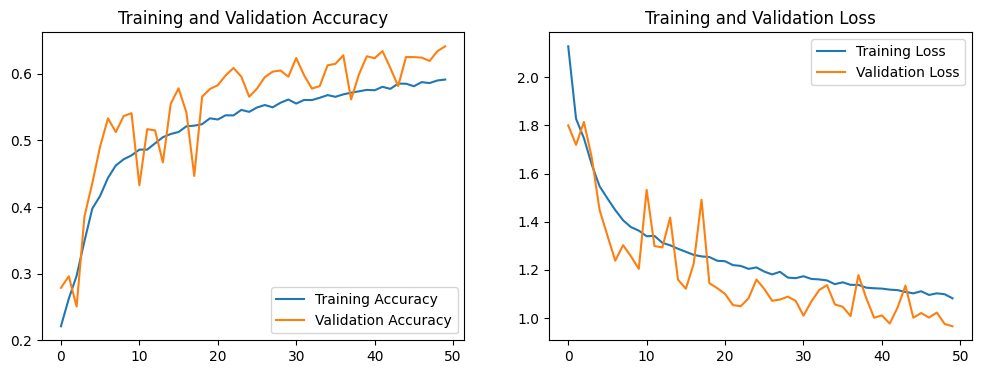

In [165]:
#Visualize model

try:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc)) # Use actual number of epochs run

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
except Exception as e:
    print(f"Could not plot training history: {e}")


In [166]:
# --- Evaluate Model ---

# Load the best saved model if EarlyStopping restored weights,
# otherwise the final model state is used. If you specifically want
# the model saved by ModelCheckpoint, load it explicitly:
# print(f"Loading best model from: {BEST_MODEL_SAVE_PATH}")
# model = load_model(BEST_MODEL_SAVE_PATH)

print("Evaluating model on the test set...")
evaluation = model.evaluate(
    validation_generator, # Using the test set generator for final evaluation
    steps=validation_steps,
    verbose=1
)

print(f"\nTest Loss: {evaluation[0]:.4f}")
print(f"Test Accuracy: {evaluation[1]*100:.2f}%")

Evaluating model on the test set...
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6127 - loss: 1.0227

Test Loss: 0.9660
Test Accuracy: 64.12%


In [167]:
#Save the final model
model.save(MODEL_SAVE_PATH)
print(f"Final move saved to : {MODEL_SAVE_PATH}")

print(f"Best Model during traning saved to: {BEST_MODEL_SAVE_PATH}" )

Final move saved to : emotion_detection_model.keras
Best Model during traning saved to: best_emotion_detection_model.keras
